# Plotting Key Global Timeseries in ACCESS-OM3

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [2]:
#parameters

### USER EDIT start
esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

# needed for mkmd START 
notebook_name='not_using_mkfigs.sh'
notebooks_dir = os.path.join(f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
from mkfigs_configdoc import mkmd,get_notebook_name
notebook_name=get_notebook_name(notebook_name)
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of another type.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
# needed for mkmd STOP

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

Changed working directory to: /g/data/tm70/cyb561/access-om3-paper-1/notebooks
Notebook name is: not_using_mkfigs.sh
ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-figs/


In [3]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime
import pandas as pd
import numpy as np


In [4]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [5]:
#datastore_path = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [6]:
tosga = datastore.search(variable="tosga").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)['tosga'].resample(time = '1YE').mean('time').load()
sosga = datastore.search(variable="sosga").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)['sosga'].resample(time = '1YE').mean('time').load()

thetaoga = datastore.search(variable="thetaoga").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)['thetaoga'].resample(time = '1YE').mean('time').load()


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/core.py:259: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

## Load ACCESS-OM2 data from ACCESS-NRI Catalog

In [7]:
catalog = intake.cat.access_nri

In [8]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='temp_global_ave',frequency="1mon")
temp_global_ave=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['temp_global_ave'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [9]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='temp_surface_ave',frequency="1mon")
temp_surface_ave=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['temp_surface_ave'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [10]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='salt_surface_ave',frequency="1mon")
salt_surface_ave=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['salt_surface_ave'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

In [11]:
var = catalog['025deg_jra55_ryf9091_gadi'].search(variable='ke_tot',frequency="1mon")
ke_tot=var.to_dask(
            xarray_open_kwargs=dict(
            chunks={"time": -1},
            decode_timedelta=True,
            use_cftime=True)
)['ke_tot'].sel(time=slice(cftime.datetime(1900, 1, 1,calendar='noleap'), cftime.datetime(1950, 12, 31,calendar='noleap'))).resample(time = '1YE').mean('time').load()

## Plot Timeseries

In [63]:
plotdates=[pd.Timestamp(daate) for daate in thetaoga.time.values]

# could figure out how to plot OM2 as they have different numbers of dates?
#np.shape(plotdates)
#np.shape(temp_global_ave)

(51, 1)

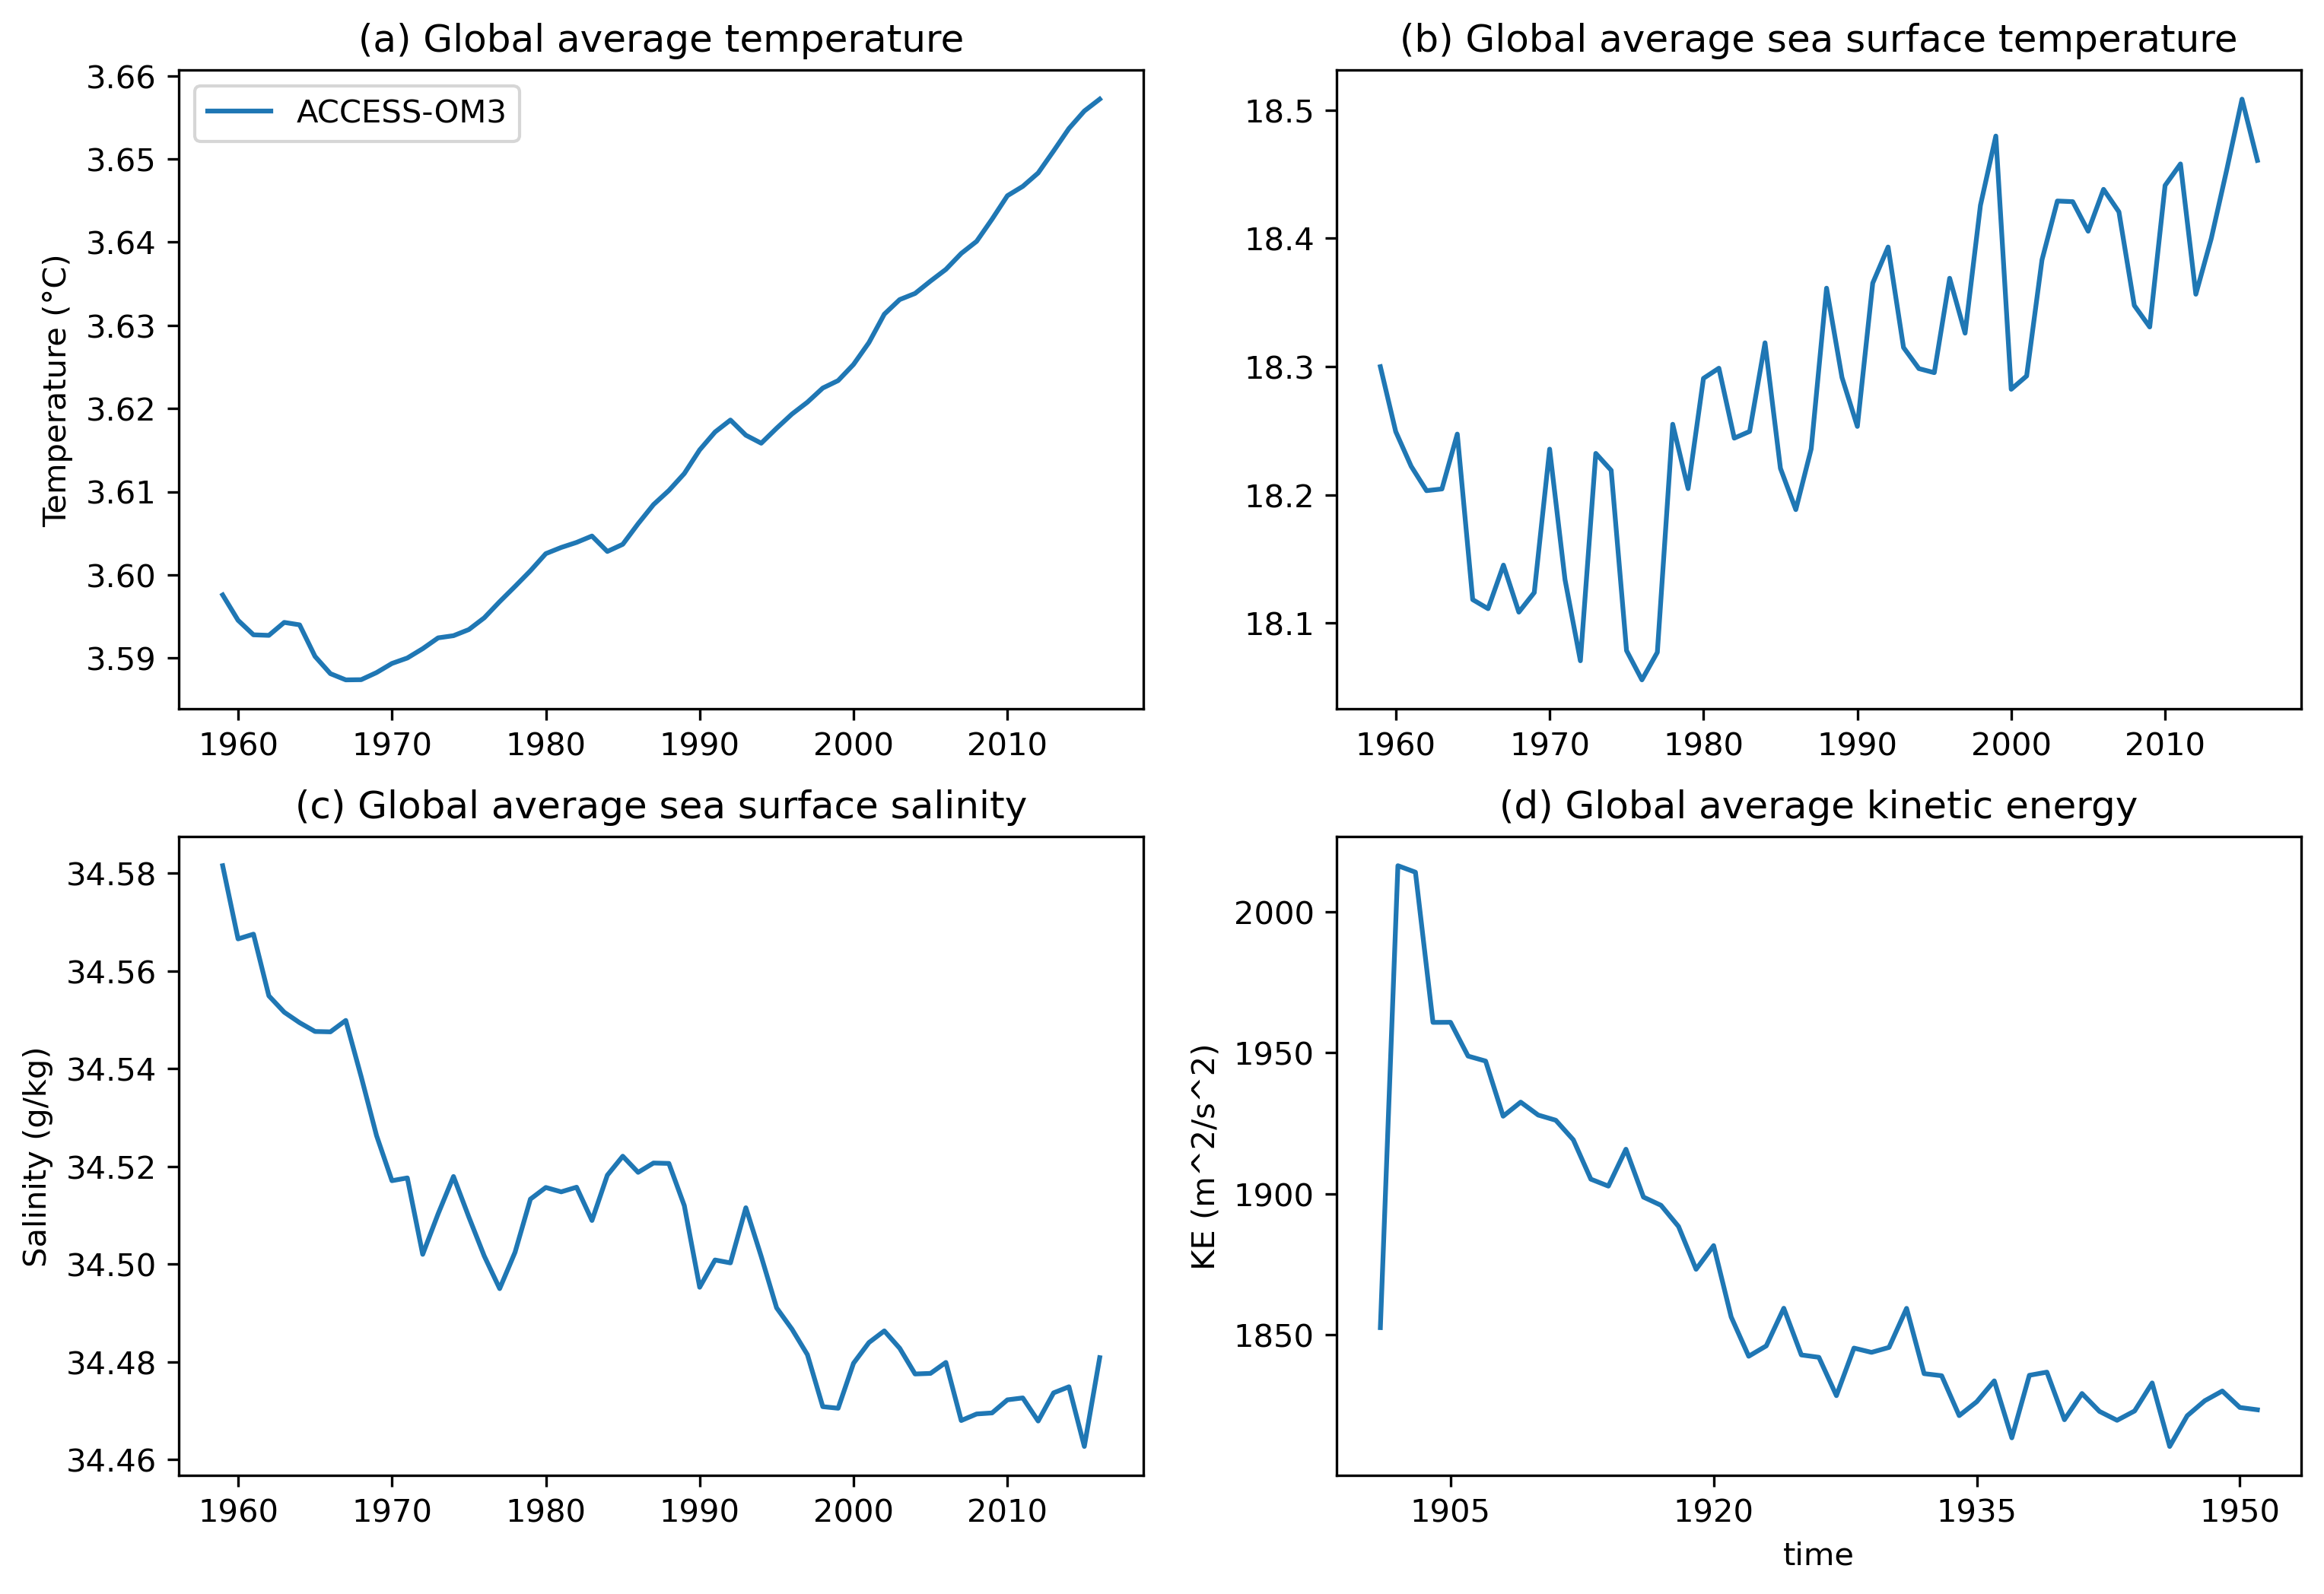

In [55]:
plt.figure(figsize=(12,8))

plt.subplot(221)
#temp_global_ave.plot(label="ACCESS-OM2")

#thetaoga.plot(label="ACCESS-OM3")
plt.plot(plotdates,np.squeeze(thetaoga.values.tolist(), axis=1),label="ACCESS-OM3")
plt.legend()
plt.ylabel('Temperature (°C)')
plt.xlabel('')
plt.title('(a) Global average temperature')

plt.subplot(222)
#temp_surface_ave.plot(label="ACCESS-OM2")
#tosga.plot(label="ACCESS-OM3")
plt.plot(plotdates,np.squeeze(tosga.values.tolist(), axis=1),label="ACCESS-OM3")
plt.ylabel('')
plt.xlabel('')
plt.title('(b) Global average sea surface temperature')

plt.subplot(223)
#salt_surface_ave.plot(label="ACCESS-OM2")
#sosga.plot(label="ACCESS-OM3")
plt.plot(plotdates,np.squeeze(sosga.values.tolist(), axis=1),label="ACCESS-OM3")
plt.ylabel('Salinity (g/kg)')
plt.title('(c) Global average sea surface salinity')

plt.subplot(224)
#ke_tot.plot(label="ACCESS-OM2")
#no_ke_diagnostic_for_om3.plot(label="ACCESS-OM3")
plt.ylabel('KE (m^2/s^2)')
plt.title('(d) Global average kinetic energy')
plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')


In [64]:

mkmd("Global Timeseries","`"+notebook_name+"`: Global average: temperature, sea surface temperature, sea surface salinity and kinetic energy. (Currently not sure how to plot OM2, needs to be fixed!)",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')

Adding a figure to markdown doc: /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkmd/MC_25km_jra_iaf-1.0-beta-5165c0f8.md
['## Global Timeseries\n', ' \n', '![`not_using_mkfigs.sh`: Global average: temperature, sea surface temperature, sea surface salinity and kinetic energy. (Currently not sure how to plot OM2, needs to be fixed!)](/assets/experiments/MC_25km_jra_iaf-1.0-beta-5165c0f8/not_using_mkf1.png){: style="height:450px;width:450px"} \n', ' \n', '  Caption: `not_using_mkfigs.sh`: Global average: temperature, sea surface temperature, sea surface salinity and kinetic energy. (Currently not sure how to plot OM2, needs to be fixed!)\n', '  \n']
Lines appended to /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkmd/MC_25km_jra_iaf-1.0-beta-5165c0f8.md successfully.



In [11]:
client.close()